## Analisis ##
En este proyecto queremos analizar cuales suelen ser los sentimientos(positivos o negativos) en las reseñas dejadas por los usuarios.
Cada reseña cuanta con una variedad de datos, que son:

• ID: A unique ID for each row in the dataset

• ProductId: A reference to the product that the review is about

• UserId: A reference to the user who left the review

• HelpfulnessNumerator: The number of readers of the review who indicated that it was "helpful"

• HelpfulnessDenominator: The total number of people who gave an indication of whether or not the review was "helpful"

• Score: The star rating (1-5)


• Time: A Unix timestamp indicating when the review was created

• Summary: The user-written summary of what the review is about

• Text: The user-written review


Lo siguiente es un paso a paso de lo que se hace para poder llegar al punto de entrenar un modelo como logistic regression o random forest

* parte 1: Preprocesamiento
            La tokenización, eliminación de stopwords, eliminacion de caracteres especiales y el filtro de palabras de alta o baja frecuencia son técnicas estándar de preprocesamiento. Sin embargo, eliminar tanto las palabras más como menos repetidas no es siempre recomendable


* parte 2: Procesamiento
            El término "procesamiento de los datos" suele llamarse extracción de características o transformación de características. Generar "bolsas de palabras" y visualizaciones como nubes de palabras son efectivamente prácticas de análisis exploratorio, no necesariamente procesamiento en sentido técnico. Aquí, podrías añadir que el procesamiento implica convertir los datos en vectores numéricos (como con bolsas de palabras o TF-IDF) para hacerlos utilizables por modelos.




* parte 3: machine learning
            Es correcto mencionar que, con los datos limpios y representados en una bolsa de palabras, se pueden usar en un modelo de machine learning. Sin embargo, el término "bolsa de palabras" representa un método de vectorización; se podrían usar otros métodos para representar datos, como TF-IDF o embeddings, antes de entrenar el modelo. Logistic regression y random forest son dos modelos válidos para datos estructurados o textuales con representación numérica, y el flujo de entrenar, predecir, y medir métricas como accuracy y f1 es también adecuado.


## Preprocesamiento ##

En la carpeta data del proyecto 2 se encuentra el archivo con el cual trabajaremos, es un csv que contiene reseñas de una variedad de productos en amazon.

Para la extraccion y manejo usaremos la libreria de pandas

In [5]:
import pandas as pd

data = pd.read_csv('../data/Reviews.csv',nrows=5000)


#se calcula la cantidad de palabras 
palabras_totales=' '.join(data['Text']).split()
print(len(palabras_totales))

375594


Para llegar a trabajar con un modelo binario como lo es logistic regression y random forest, necesitamos clasificar todas las reseñas bajo dos partes, reseñas de sentimientos positivos y reseñas de sentimientos negativos con el fin de tener una clasificacion para aumentar la presicion de un entrenamiento.

los registros van a ser evaluados segun las  estrellas(1-5).  las reseñas que tengan 4 o 5 estrellas, seran evaluadas con un puntaje de 1 para indicar que la reseña es de sentimientos positivos, las reseñas que tengan 1-2 estrellas seran evaluadas con un cero para indicar que la reseña es de sentimientos negaticos, y las reseñas que esten con una calificacion de 3 estrellas seran eliminadas.

In [6]:
import numpy as np

#agregar una columna nueva para el rating sentimental
data['Sentimental'] = np.where(data['Score'] >= 4, 1, np.where(data['Score'] <= 2, 0, data['Score']))


# Eliminar las filas donde 'Score' sea igual a 3 (si es necesario)
index_to_drop = data[data['Sentimental'] == 3].index

# Crear un nuevo DataFrame sin las filas que cumplen la condición
data_clean = data.drop(index_to_drop)

Se cambian todas las palabras de la columna de texto a minusculas, ademas se eliminan los caracteres especiales


In [7]:
import re

#convertir todos los textos necesarios a minusculas+
data_clean['Text']=data_clean['Text'].str.lower()


# Convertir a minúsculas y eliminar caracteres especiales en las dos columnas
data_clean['Text'] = data_clean['Text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))


Se realiza la tokenizacion de palabras de la columna texto, y a su vez se eliminan los stop words

In [ ]:
import nltk
from nltk.corpus import stopwords  

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


#se agrega una columna con las palabras tokenizadas
data_clean['TextTokens']=data_clean['Text'].apply(lambda x: nltk.word_tokenize(x))


#se eliminan los stopwords de los tokens
data_clean['TextTokens'] = data_clean['TextTokens'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])


[nltk_data] Downloading package stopwords to C:\Users\MARTHA ISABEL
[nltk_data]     VILLAM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Procesamiento de datos #

Se eliminan las palabras mas y menos repetidas

In [9]:
from sklearn.feature_extraction.text import CountVectorizer as cv

#convertir los tokens a texto
data_clean['TextClean']=data_clean['TextTokens'].apply(lambda tokens: ' '.join(tokens) )

vectorizer = cv()

#se genera la matriz de frecuencia
matriz_frecuencia = vectorizer.fit_transform(data_clean['TextClean'])


#Obtener las palabras y sus frecuencias
word_freq = matriz_frecuencia.toarray().sum(axis=0)
vocab = vectorizer.get_feature_names_out()


# Crear un DataFrame para almacenar palabras y frecuencias
word_counts_df = pd.DataFrame({'Palabra': vocab, 'Frecuencia': word_freq})


# Obtener las palabras más y menos repetidas
palabras_mas_repetidas = word_counts_df.nlargest(20, 'Frecuencia')['Palabra'].tolist()
palabras_menos_repetidas = word_counts_df.nsmallest(20, 'Frecuencia')['Palabra'].tolist()


#eliminamos las palabras mas repetidas de los tokens
data_clean['TextTokens']=data_clean['TextTokens'].apply(lambda tokens: [word for word in tokens if word not in palabras_mas_repetidas] )
data_clean['TextTokens']=data_clean['TextTokens'].apply(lambda tokens: [word for word in tokens if word not in palabras_menos_repetidas] )



Realizamos una nube de palabras para ver como estan los textos positivos y negativos teniendo en cuenta la calificacion de score establecida anterioremente
score = 1 (positivos)
score = 0 (negativo)

En una nue de palabras se muestra la cantidad de de veces que aparece una palabra equivalente en tamaño, eso quiere decir que si una palabra se repide mucho, sera mas grande

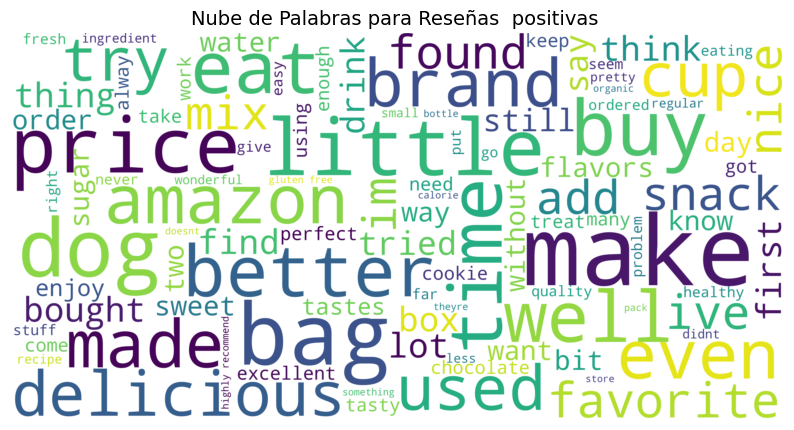

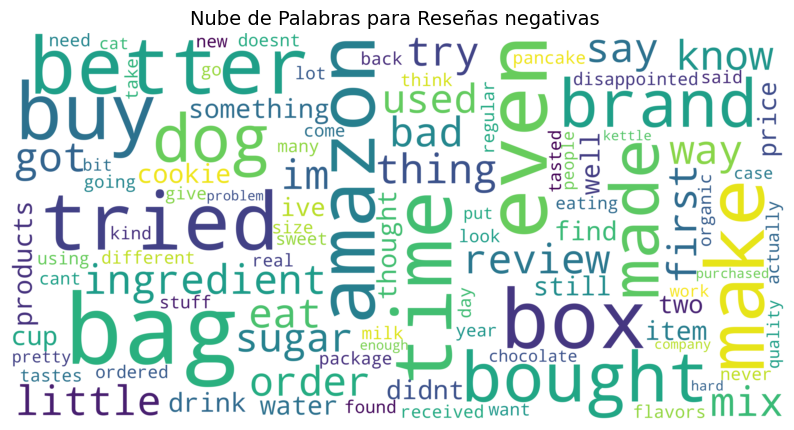

In [10]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

data_clean['TextClean']=data_clean['TextTokens'].apply(lambda tokens: ' '.join(tokens))



#unimos todos los textos de los comentarios positivos
reviews_pos=data_clean[data_clean['Sentimental']==1]
all_reviews_pos=' '.join(reviews_pos['TextClean'])

#unimos todos los textos de los comentarios negativos
reviews_neg=data_clean[data_clean['Sentimental']==0]
all_reviews_neg=' '.join(reviews_neg['TextClean'])


# Generar la nube de palabras
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white", scale=10, width=800, height=400).generate(all_reviews_pos)
    
# Visualizar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(f'Nube de Palabras para Reseñas  positivas ', fontsize=14)
plt.show()


# Generar la nube de palabras
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white", scale=10, width=800, height=400).generate(all_reviews_neg)
    
# Visualizar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(f'Nube de Palabras para Reseñas negativas ', fontsize=14)
plt.show()





Is removing special characters even a good idea? What are some examples of characters that would likely be safe to remove, and what are some that would not be?

Respond: i think that remove the characters is very ussefull because there are characters that his meaning is not important for the context, some examples of special characters are (!,#,&,@,) this are some examples about the special characters, and the characters that i need, are all letters and numbers

## machine learning

## modelo de regresion logistica ## 

Este es un modelo entregado por la libreria sklearn, el cual esta diseñado para hacer predicciones de datos. este se alimenta con 
muchos tipos de datos bajo cierta clasificacion(en nuestro caso positivo=1 y negativo=0 segun la evaluacion para cada reseña en amazon)

el proceso consiste en tomar la cantidad de datos a usar, establecer cuales seran las variables que se usaran para clasifica los datos y entrenar el modelo, luego se dividen los datos una parte para entrenar el modelo, y otra para probar el nivel de prediccion. generalmente 80% para entrenar y 20% para probar

Como primera parte, creamos una bolsa de palabras con la cual se va a alimentar el modelo, para generar esta bolsa de palabras de emplea el proceso tfidf aplicando tfidfvectorizer

In [11]:
from sklearn.feature_extraction.text import CountVectorizer # se usa para crear la bolsa de palabras
from nltk.tokenize import word_tokenize  # se usa para tokenizar
from sklearn.feature_extraction.text import TfidfVectorizer


nltk.download('punkt')  # Para tokenización
nltk.download('stopwords')  # Para las palabras vacías

#stopWrods (aunque anteriormente ya se eliminaron)
noise_words = nltk.corpus.stopwords.words('english')

# Crear el objeto CountVectorizer para generar una amtriz dispersa
vectorizer = TfidfVectorizer(tokenizer=word_tokenize, ngram_range=(1, 4))


[nltk_data] Downloading package punkt to C:\Users\MARTHA ISABEL
[nltk_data]     VILLAM\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\MARTHA ISABEL
[nltk_data]     VILLAM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Extraemos los datos de entrenamiento y de prueba y para esto usamos la libreria que ya nos provee no solo el modelo si no la forma de separar los datos para entrenar el modelo. y luego se genera y se entrena el modelo con los datos entregados por la primera funcion

hay que tener en cuenta la vecotirzacion tfidf se aplica depsues de separar los datos y no antes con tal de conservar informacion de las predicciones

In [12]:
from sklearn.model_selection import train_test_split # funcion para separar los datos para trabajar con el modelo
from sklearn.linear_model import LogisticRegression #modelo de regresion logistica

#Extraemos los review para entrenar, para testear, 
reviews_train,reviews_test = train_test_split(data_clean,test_size=0.2,random_state=0)

#creamos una bolsa de palabras sobre los datos separados
x_bow_train=vectorizer.fit_transform(reviews_train['TextClean'])
x_bow_test=vectorizer.transform(reviews_test['TextClean'])

y_train=reviews_train['Sentimental']
y_test=reviews_test['Sentimental']

#creamos el modelo
model = LogisticRegression(C=10,solver='liblinear')

#entrenamos el modelo
model.fit(x_bow_train,y_train)

c:\Users\MARTHA ISABEL VILLAM\AppData\Local\pypoetry\Cache\virtualenvs\proyecto_de_yelp-j_kxu5WQ-py3.12\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


LogisticRegression(C=10, solver='liblinear')

Hacemos la prediccion con los datos que sacamos para las pruebas y hacemos la evaluacion para ver que tanto acerto nuestro modelo


In [13]:
from sklearn.metrics import accuracy_score,f1_score

#calculamos las probabilidades de predicción
predicted_probabilities = model.predict_proba(x_bow_test)

#se hace la preddicion
prediccion = model.predict(x_bow_test)

#porcentaje de aciertos
accuracy=accuracy_score(y_test,prediccion)

#nivel de presicion
f1 = f1_score(y_test,prediccion)



print(accuracy)#porcentaje de aciertos
print(f1)#probabilidad de fallar

            

0.8773072747014115
0.931804465902233


Se el analisis, uno a uno de los resultados los cuales dieron una respuesta erronea en la prediccion

In [14]:
probabilities = [each[1] for each in predicted_probabilities]

#se genera un dataframe que coleccione los datos de todas las predicciones
prediccions=pd.DataFrame()
prediccions['Text']=reviews_test['Text']
prediccions['Score']=reviews_test['Score']
prediccions['Sentimental']=reviews_test['Sentimental']
prediccions['Predict']=prediccion
prediccions['Predict_prob']=probabilities

#imprimimos las predicciones que se equivocaron y mostramos sus datos
for index,item in prediccions.iterrows():
    if(int(item['Sentimental'])!=int(item['Predict'])):
        print(item)

Text            i wish i had read the product description bett...
Score                                                           1
Sentimental                                                     0
Predict                                                         1
Predict_prob                                             0.573383
Name: 2682, dtype: object
Text            i have been drinking green tea powder for a fe...
Score                                                           1
Sentimental                                                     0
Predict                                                         1
Predict_prob                                             0.800268
Name: 2620, dtype: object
Text            the food and drug administration fda is again ...
Score                                                           1
Sentimental                                                     0
Predict                                                         1
Predict_prob            

Se imprime la reseña negativa que mas tenia probabilidad de ser correcta, pero aun asi su resultado fue erroneo. es decir, se tomaran todas las reseñas que se predijeron como un 0 en el sentimental rating pero en realidad era 1, y de todas esas reseñas se imprime la que aparentemente tenia mas probabilidad de ser correcta pero no fue asi

In [15]:
i = None#almacenara el item errado con mayor probabilidad

mayor_probabilidad=0#variable para encontrar la mayor probabilidad


for index, item in prediccions.iterrows():
    if(item['Predict']==0 and item['Predict_prob']>mayor_probabilidad):
        mayor_probabilidad=item['Predict_prob']
        i=item

print(i)


Text            this does not work on windows 7 tried reinstat...
Score                                                           1
Sentimental                                                     0
Predict                                                         0
Predict_prob                                             0.499055
Name: 4107, dtype: object


La razón por la que algunos textos no se predicen correctamente y tienen porcentajes bajos de predicción se debe a la gran variedad de expresiones y formas en que las personas pueden expresar descontento o insatisfacción. Existen reseñas que contienen palabras o patrones que el modelo no ha aprendido o interpretado correctamente, lo cual las convierte en "desconocidas" para él. Cuantas más palabras y expresiones nuevas o poco comunes tenga una reseña, mayor será la dificultad para que el modelo acierte, ya que es menos probable que pueda generalizar correctamente en estos casos.

# Random forest #


Entrenamos un modelo nuevo llamado random forest, este modelo es altamente especialista en dato multifactor, es decir, dependen de varias variables al tiempo, siendo capaz de encontrar patrones complejos, aunque tambien puede ser usando en un modelo lineal como el ejemplo actual usado. la forma de separar los datos y entrenar el modelo es muy similar a logistic regression

In [16]:
from sklearn.ensemble import RandomForestClassifier

# Ejemplo básico con 100 árboles
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)

rf_model.fit(x_bow_train,y_train)#se entrena el nuevo modelo


#se hace la preddicion
rf_prediccion = rf_model.predict(x_bow_test)

#porcentaje de aciertos
rf_accuracy=accuracy_score(y_test,rf_prediccion)

#nivel de presicion
rf_f1 = f1_score(y_test,rf_prediccion)



#se hace una comparacion de los resultados entregados por logistic regression y random forest
print(f'el accuracy del modelo de logistic regresion es: {accuracy}')#porcentaje de aciertos
print(f'el f1 del modelo de logistic regresion es: {f1}')#probabilidad de fallar

print(f'el accuracy del modelo de  random forest es: {rf_accuracy}')#porcentaje de aciertos
print(f'el f1 del modelo de  random forest es: {rf_f1}')#probabilidad de fallar

el accuracy del modelo de logistic regresion es: 0.8773072747014115
el f1 del modelo de logistic regresion es: 0.931804465902233
el accuracy del modelo de  random forest es: 0.8512486427795874
el f1 del modelo de  random forest es: 0.918982850384388


Ahora, se genera una nueva bolsa de palabras pero, ademas de ysar tfidf vectorizer se usara con 200 palabras mas importantes y con base en estas, analiza caad registro

In [17]:
# Crear el vectorizador con 200 características
vectorizer = TfidfVectorizer(tokenizer=word_tokenize, max_features=200)

# Ajustar y transformar los datos de entrenamiento
datos_vectorizados = vectorizer.fit_transform(data_clean['TextClean'])


# Convertir las primeras 10 filas a un DataFrame
df_tfidf = pd.DataFrame(datos_vectorizados[:10].toarray(), columns=vectorizer.get_feature_names_out())
print(df_tfidf)

c:\Users\MARTHA ISABEL VILLAM\AppData\Local\pypoetry\Cache\virtualenvs\proyecto_de_yelp-j_kxu5WQ-py3.12\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


     1    2    3    4    5  actually  add  almost      also  always  ...  way  \
0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0     0.0  0.000000     0.0  ...  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.589354  0.0     0.0  0.000000     0.0  ...  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.000000  0.0     0.0  0.000000     0.0  ...  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.000000  0.0     0.0  0.000000     0.0  ...  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.000000  0.0     0.0  0.000000     0.0  ...  0.0   
5  0.0  0.0  0.0  0.0  0.0  0.000000  0.0     0.0  0.000000     0.0  ...  0.0   
6  0.0  0.0  0.0  0.0  0.0  0.000000  0.0     0.0  0.000000     0.0  ...  0.0   
7  0.0  0.0  0.0  0.0  0.0  0.000000  0.0     0.0  0.000000     0.0  ...  0.0   
8  0.0  0.0  0.0  0.0  0.0  0.000000  0.0     0.0  0.000000     0.0  ...  0.0   
9  0.0  0.0  0.0  0.0  0.0  0.000000  0.0     0.0  0.265667     0.0  ...  0.0   

       well  white  whole  without  wonderful  work  worth  year  years  
0  0.000000    0.0    0.0      0.0

Se carga un modelo, el cual esta previamente entrenado con un numero de palabras que conservan similitud o comparten contexto

In [18]:
import gensim
import os

# Cargar el modelo GloVe preentrenado en formato Word2Vec desde la carpeta data
model = gensim.models.KeyedVectors.load_word2vec_format(
    os.path.join('../data', 'glove.twitter.27B.200d_out.txt'),
    binary=False,
    unicode_errors='ignore'
)


In [19]:
def print_similarity(word1, word2, model):
    v1 = model[word1]
    v2 = model[word2]
    similarity = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    print(f"{word1} and {word2} are {round(similarity * 100)}% similar")


print_similarity("cat", "dog", model)
print_similarity("good", "bad", model)
print_similarity("great", "good", model)
print_similarity("grass", "model", model)

cat and dog are 83% similar
good and bad are 80% similar
great and good are 87% similar
grass and model are 11% similar
